In [19]:
# Import de l'ensemble des packages nécessaires

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten

In [2]:
df = pd.read_csv('fusion3.csv', low_memory=False)

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date','com'], axis=1)
df['place'] = df['place'].astype('object')
df['dep'] = df['dep'].replace({'2A':201,'2B':202})
df['dep'] = df['dep'].astype('int64')

df = df.dropna()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291745 entries, 0 to 2291796
Data columns (total 34 columns):
 #   Column              Dtype  
---  ------              -----  
 0   place               object 
 1   catu                object 
 2   grav                object 
 3   sexe                object 
 4   trajet              object 
 5   locp                object 
 6   actp                object 
 7   etatp               object 
 8   secuUn              object 
 9   tranches_ages       object 
 10  catr                object 
 11  circ                object 
 12  nbv                 float64
 13  vosp                object 
 14  prof                object 
 15  plan                object 
 16  surf                object 
 17  infra               object 
 18  situ                object 
 19  obs                 object 
 20  obsm                object 
 21  choc                object 
 22  manv                object 
 23  catv_Label          object 
 24  lum                 obje

In [5]:
# Affichage du nombre de lignes et de colonnes
nb_lignes, nb_colonnes = df.shape
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")

Nombre de lignes : 2291745
Nombre de colonnes : 34


# Encodage et normalisation des variables

In [6]:
df['grav'] = df['grav'].astype('category')

In [7]:
valeurs_grav = df['grav'].unique()
print("Différentes valeurs de la variable 'grav':")
print(valeurs_grav)

Différentes valeurs de la variable 'grav':
['Blessé léger', 'Blessé hospitalisé', 'Indemne', 'Tué']
Categories (4, object): ['Blessé hospitalisé', 'Blessé léger', 'Indemne', 'Tué']


In [8]:
# Définition de la correspondance entre les labels et les numéros
label_mapping = {'Blessé léger': 1, 'Blessé hospitalisé': 2, 'Indemne': 0, 'Tué': 3}

# Application de la correspondance à la colonne 'grav' dans l'ensemble de données
df['grav'] = df['grav'].map(label_mapping)

df['grav'] = df['grav'].astype('category')

In [20]:
# Division du dataframe en jeu d'entraînement et jeu de test tout en maintenant la distribution des classes
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['grav'], random_state=42)

# Réduction de la taille combinée des jeux d'entraînement et de test pour pas qu'elle dépasse 50% du total 
# compte tenu du problème de mémoire du PC
max_size = 0.50 * len(df)
if len(train_df) + len(test_df) > max_size:
    # Calcul de la taille du jeu de test proportionnellement à la taille du jeu d'entraînement
    test_size = int(max_size * (len(test_df) / (len(train_df) + len(test_df))))
    test_df = df[df.index.isin(test_df.index)].sample(n=test_size, random_state=42)

# Affichage des informations sur la taille des jeux de données
print(f"Taille du jeu d'entraînement : {len(train_df)}")
print(f"Taille du jeu de test : {len(test_df)}")

Taille du jeu d'entraînement : 1833396
Taille du jeu de test : 229174


In [21]:
# Séparation des caractéristiques (X) de la variable cible (y)
X_train = train_df.drop('grav', axis=1)
y_train = train_df['grav']
X_test = test_df.drop('grav', axis=1)
y_test = test_df['grav']

In [22]:
# Affichage du type de chaque variable dans X_train
print("Types de variables dans X_train :")
print(X_train.dtypes)

# Affichage du type de la variable y_train
print("\nType de la variable y_train :")
print(y_train.dtype)

# Affichage du type de chaque variable dans X_test
print("\nTypes de variables dans X_test :")
print(X_test.dtypes)

# Affichage du type de  la variable y_test
print("\nType de la variable y_test :")
print(y_test.dtype)


Types de variables dans X_train :
place                  object
catu                   object
sexe                   object
trajet                 object
locp                   object
actp                   object
etatp                  object
secuUn                 object
tranches_ages          object
catr                   object
circ                   object
nbv                   float64
vosp                   object
prof                   object
plan                   object
surf                   object
infra                  object
situ                   object
obs                    object
obsm                   object
choc                   object
manv                   object
catv_Label             object
lum                    object
agg                    object
int                    object
atm                    object
col                    object
dep                     int64
jour_de_la_semaine     object
heure                   int64
month                   int64
day   

In [23]:
# Encodage des variables catégorielles dans les données d'entraînement
X_train_encoded = pd.get_dummies(X_train)

# Encodage des variables catégorielles dans les données de test en utilisant les colonnes de référence des données d'entraînement
X_test_encoded = pd.get_dummies(X_test, columns=X_train.columns)

# Vérification et ajout des colonnes manquantes aux données de test
missing_columns = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for column in missing_columns:
    X_test_encoded[column] = 0 

# Réorganisation des colonnes dans les données de test pour qu'elles soient dans le même ordre que celles des données d'entraînement
X_test_encoded = X_test_encoded[X_train_encoded.columns]


C:\Users\anfh\AppData\Local\Temp\ipykernel_7952\462037034.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_train_encoded = pd.get_dummies(X_train)
C:\Users\anfh\AppData\Local\Temp\ipykernel_7952\462037034.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_test_encoded = pd.get_dummies(X_test, columns=X_train.columns)


In [24]:
# Normalisation des variables numériques 
scaler = StandardScaler()
X_train_encoded[['nbv']] = scaler.fit_transform(X_train_encoded[['nbv']])
X_test_encoded[['nbv']] = scaler.transform(X_test_encoded[['nbv']])

## Application d'un modèle d'un réseau de neurones avec Keras - Architecture fixe trois couches denses

In [25]:
# Définition du modèle
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(X_train_encoded.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(90, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               51600     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 90)                18090     
                                                                 
 dropout_3 (Dropout)         (None, 90)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 364       
                                                                 
Total params: 70054 (273.65 KB)
Trainable params: 70054 (273.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Compilation du modèle avec des poids de classe
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [27]:
# Entraînement du modèle avec callbacks
history = model.fit(X_train_encoded, y_train, epochs=50, validation_split=0.1, class_weight=class_weights,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
51565/51565 [==============================] - 140s 3ms/step - loss: 1.0537 - accuracy: 0.5345 - val_loss: 0.9839 - val_accuracy: 0.5641
Epoch 2/50
   19/51565 [..............................] - ETA: 2:51 - loss: 1.0878 - accuracy: 0.5806

C:\Users\anfh\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51565/51565 [==============================] - 137s 3ms/step - loss: 1.0115 - accuracy: 0.5524 - val_loss: 0.9779 - val_accuracy: 0.5655
Epoch 3/50
51565/51565 [==============================] - 136s 3ms/step - loss: 1.0053 - accuracy: 0.5565 - val_loss: 0.9917 - val_accuracy: 0.5487
Epoch 4/50
51565/51565 [==============================] - 139s 3ms/step - loss: 1.0032 - accuracy: 0.5574 - val_loss: 0.9707 - val_accuracy: 0.5725
Epoch 5/50
51565/51565 [==============================] - 136s 3ms/step - loss: 1.0010 - accuracy: 0.5592 - val_loss: 0.9670 - val_accuracy: 0.5585
Epoch 6/50
51565/51565 [==============================] - 139s 3ms/step - loss: 0.9998 - accuracy: 0.5597 - val_loss: 0.9367 - val_accuracy: 0.5727
Epoch 7/50
51565/51565 [==============================] - 138s 3ms/step - loss: 0.9991 - accuracy: 0.5601 - val_loss: 0.9929 - val_accuracy: 0.5519
Epoch 8/50
51565/51565 [==============================] - 140s 3ms/step - loss: 0.9996 - accuracy: 0.5604 - val_loss: 0.967

In [28]:
# Évaluation du modèle sur le jeu de test
accuracy = model.evaluate(X_test_encoded, y_test)[1]
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")

7162/7162 [==============================] - 21s 3ms/step - loss: 2.3662 - accuracy: 0.5897
Précision sur le jeu de test : 58.97%


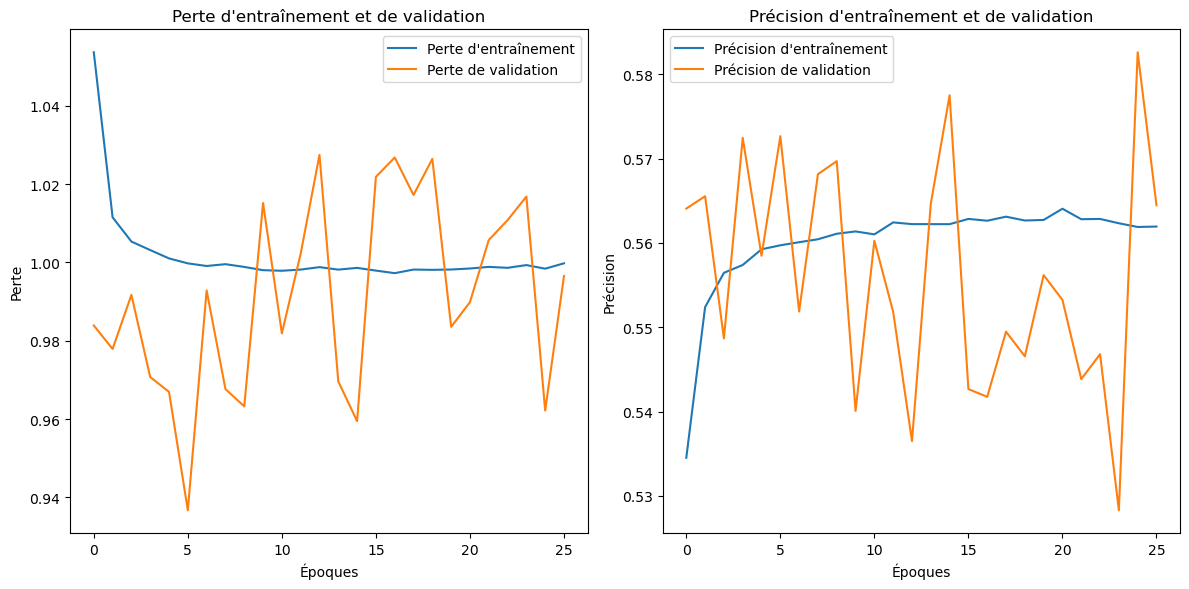

7162/7162 [==============================] - 21s 3ms/step - loss: 2.3662 - accuracy: 0.5897
Perte sur le jeu de test : 2.3662
Précision sur le jeu de test : 58.97%
7162/7162 [==============================] - 21s 3ms/step


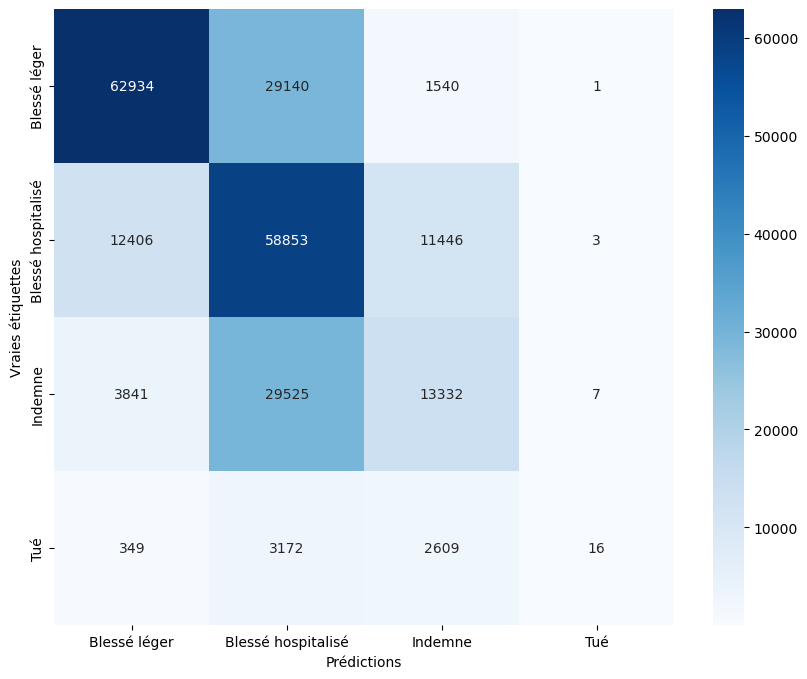

Rapport de classification :
                     precision    recall  f1-score   support

      Blessé léger       0.79      0.67      0.73     93615
Blessé hospitalisé       0.49      0.71      0.58     82708
           Indemne       0.46      0.29      0.35     46705
               Tué       0.59      0.00      0.01      6146

          accuracy                           0.59    229174
         macro avg       0.58      0.42      0.42    229174
      weighted avg       0.61      0.59      0.58    229174



In [29]:

# Affichage de l'évolution de la perte et de la précision
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Perte d\'entraînement')
plt.plot(validation_loss, label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Précision d\'entraînement')
plt.plot(validation_accuracy, label='Précision de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Précision d\'entraînement et de validation')
plt.legend()

plt.tight_layout()
plt.show()

# Évaluation du modèle sur le jeu de test
test_loss, test_accuracy = model.evaluate(X_test_encoded, y_test)
print(f"Perte sur le jeu de test : {test_loss:.4f}")
print(f"Précision sur le jeu de test : {test_accuracy * 100:.2f}%")

# Prédictions sur le jeu de test
y_pred_probs = model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred_classes, target_names=label_mapping.keys()))

Ce modèle présente une précision globale de 58.97% sur le jeu de test, mais des performances inégales par classe. 

Il réussit bien à prédire les blessés légers et hospitalisés, mais a des difficultés avec les indemnes et a une recall très basse pour la classe "Tué". 

La matrice de confusion indique la nécessité d'améliorer la distinction entre les classes minoritaires. 

Nous allons poursuivre l'insertion d'ajustements dans l'architecture du modèle, l'utilisation de techniques d'équilibrage de classe pour améliorer la performance.